In [5]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

In [34]:
def find_formants_1(speech_file, order=5, plot=True):
    # Read the audio file
    signal, sample_rate = librosa.load(speech_file, sr=None)

    # Ensure mono audio
    if signal.ndim > 1:
        signal = signal[:, 0]

    # Compute the autocorrelation of the signal
    autocorr = librosa.autocorrelate(signal)

    # Compute the LPC coefficients using the autocorrelation
    lpc_coeffs = librosa.lpc(signal, order=order)

    # Compute the roots of the LPC coefficients to find the formants
    roots = np.roots(lpc_coeffs)
    roots = roots[np.imag(roots) >= 0]

    # Compute the angles of the roots
    angles = np.arctan2(np.imag(roots), np.real(roots))

    # Convert angles to frequencies
    frequencies = angles * (sample_rate / (2 * np.pi))

    if plot:
        # Plot the autocorrelation
#         plt.figure(figsize=(10, 4))
#         plt.plot(autocorr)
#         plt.xlabel('Lag')
#         plt.ylabel('Autocorrelation')
#         plt.title('Autocorrelation')
#         plt.grid(True)
#         plt.show()

        # Plot the formants on the spectrogram
        plt.figure(figsize=(10, 6))
        plt.specgram(signal, NFFT=512, Fs=sample_rate, cmap='inferno')
        plt.colorbar(format='%+2.0f dB')
        plt.xlabel('Time')
        plt.ylabel('Frequency')
        plt.title('Spectrogram with Formants')
        plt.plot(np.arange(len(frequencies)) * len(signal) / len(frequencies) / sample_rate, frequencies,
                 marker='o', markersize=8, linewidth=0, color='white')
        plt.ylim(0, 5000)
        plt.show()

    return frequencies

def find_formants_2(speech_file, order=12, plot=True):
    # LPC order (adjust as needed)

    # Read the audio file
    signal, sr = librosa.load(speech_file, sr=None)

    # Define frame parameters
    frame_length = int(0.025 * sr)  # Frame length in samples
    hop_length = int(0.010 * sr)  # Hop length in samples

    # Compute the frames of the speech signal
    frames = librosa.util.frame(signal, frame_length=frame_length, hop_length=hop_length).T

    # Initialize the list to store formants
    formants = []

    # Iterate over the frames and estimate formants
    for frame in frames:
        # Compute the autocorrelation of the frame
        autocorr = librosa.autocorrelate(frame, max_size=int(0.03 * sr))

        # Estimate the formant frequencies using LPC
        lpc_coeff = librosa.lpc(frame, order=order)
        roots = np.roots(lpc_coeff)

        # Extract the formant frequencies from the roots of the LPC polynomial
        frame_formants = []
        for r in roots:
            if np.imag(r) >= 0:
                frame_formants.append(sr / (2 * np.pi * np.angle(r)))

        formants.append(frame_formants)

    # Convert the formants list to a NumPy array
    formants = np.array(formants)

    # Plot the formant trajectories
    if plot:
        plt.figure(figsize=(10, 6))
        plt.imshow(formants.T, origin='lower', aspect='auto', cmap='inferno')
        plt.colorbar(format='%g Hz')
        plt.xlabel('Frame')
        plt.ylabel('Formant')
        plt.title('Formant Trajectories')
        plt.tight_layout()
        plt.show()
    return formants

def find_formant(filename):
    # Load the audio file
    # filename = 'your_audio_file.wav'  # Replace with your file path
    y, sr = librosa.load(filename, sr=48000)

    # Apply pre-emphasis filter
    pre_emphasis = 0.97
    y = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

    # Frame the signal into short frames
    frame_size = int(sr * 0.025)
    num_frames = len(y) // frame_size
    print('num_frames', num_frames)
    frames = np.zeros((num_frames, frame_size))

    for i in range(num_frames):
        frames[i, :] = y[i*frame_size : (i+1)*frame_size]

    # Compute the LPC coefficients for each frame
    order = 2 + sr // 1000
    lpc_coeffs = np.zeros((num_frames, order+1))

    for i in range(num_frames):
        lpc_coeffs[i, :] = librosa.lpc(frames[i, :], order) # [num_frames, order+1]

    # Get formant frequencies for each frame
    formants = np.zeros((num_frames, order))  # (128, 50)

    for i in range(num_frames):
        roots = np.roots(lpc_coeffs[i, :])  #  roots represent the resonant frequencies (or formants)
        roots = [root for root in roots if np.imag(root) >= 0 and np.abs(root) > 0.95 and np.abs(root) < 1.05]
        freqs = sorted(np.arctan2(np.imag(roots), np.real(roots)))
        formants[i, :len(freqs)] = [freq * sr / (2 * np.pi) for freq in freqs]

        # formants[i, :] = [freq * sr / (2 * np.pi) for freq in freqs]

    # Average formant frequencies across frames
    mean_formants = np.mean(formants, axis=0)
    return formants, mean_formants

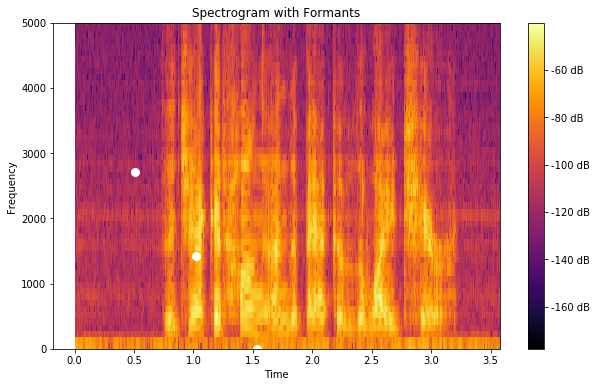

[10386.036   2708.4475  1420.4159     0.     16917.764  21468.615
 24000.002 ]

num_frames 143
[    0.         10516.67783765 11469.28561726 12606.18399545
 16457.84995029 19406.26520935 20315.65287591 21503.77990335
 22331.04507904 23387.79235277     0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.        ]


In [35]:
# Load the speech signal (example path)
speech_file = 'data/no-noise/sim_NM_amp_nn_oc02_h17_1.wav'

# Find the formants
formants1 = find_formants_1(speech_file, order=12, plot=True)
print(formants1)
print()

# formants2 = find_formants_2(speech_file, order=12, plot=False)
# for i, formant in enumerate(formants):
#     print(f"Formant {i+1}: {formant} Hz", end=' ')

formants, mean_formants = find_formant(speech_file)
print(formants[0])
Audio(speech_file)